<div style="text-align: center;">
    <h1>AI CA 5</h1>
</div>

<div style="text-align: center;">
    Farbod Azimmohseni 810100187
</div>

# Image Normalization:
Data normaliztion rescale data to speed up convergence.
It also makes all samples uniform. The reason why we dont use image normalization is it may destroy differences between samles. This becomes problem in dataset like this one that we dont have any image diversity. I also tried and my model had difficulty converging.

# Train Test Split:
I have seperated data with 80/20 ratio. Which is a really normal spliting ratio. If we had validation set it would be different. Splitting was done on each class seperatly in order to balance data.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch.nn as nn
import torch
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from sklearn.model_selection import train_test_split
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch.nn.functional as F


import os


In [3]:
torch_device = torch.device("cuda")

In [4]:
classes = ['glioma','meningioma','notumor','pituitary']

N_CLASSES = 4

data_path = '/content/drive/MyDrive/AI-CA5-Dataset/'



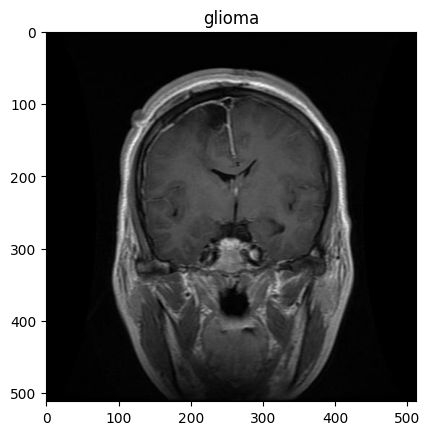

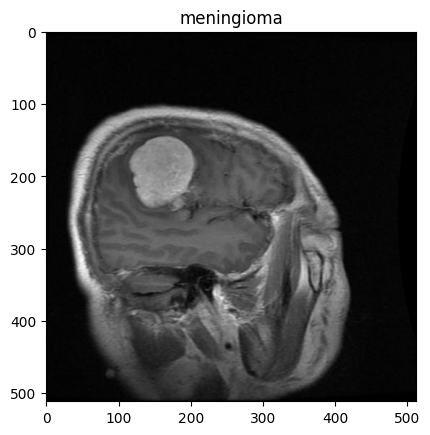

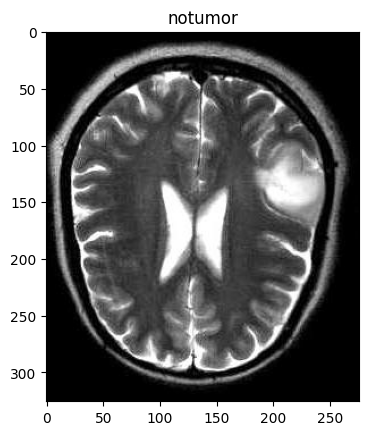

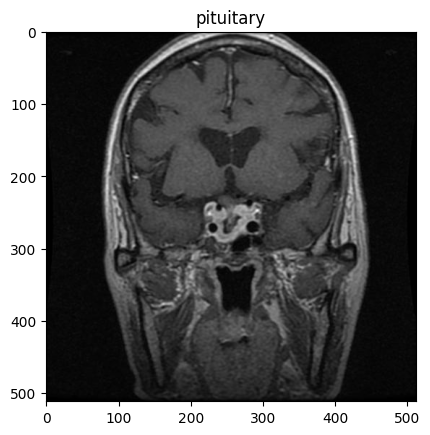

In [5]:

train_list = []
test_list = []
test_amount = []
train_amount = []

for i in range(N_CLASSES):

  file_list = os.listdir(data_path+classes[i])
  images = []
  c =0
  for img in file_list:
    img_path = os.path.join(data_path+classes[i], img)
    c+=1
    # print(img_path)
    images.append(img_path)
  x_train,x_test,y_train,y_test = train_test_split(images,[i]*c,test_size=0.2)
  plt.imshow(cv2.imread(x_train[0]))
  plt.title(classes[i])
  plt.show()
  train_amount.append(len(x_train))
  test_amount.append(len(x_test))
  for j in range(len(x_train)):
    x_train[j] = cv2.imread(x_train[j])
  for j in range(len(x_test)):
    x_test[j] = cv2.imread(x_test[j])
  temp_train = [w for w in zip(x_train, y_train)]
  temp_test = [w for w in zip(x_test, y_test)]

  if train_list:
    train_list.extend(temp_train)
    test_list.extend(temp_test)
  else:
    train_list = list(temp_train)
    test_list = list(temp_test)

[]

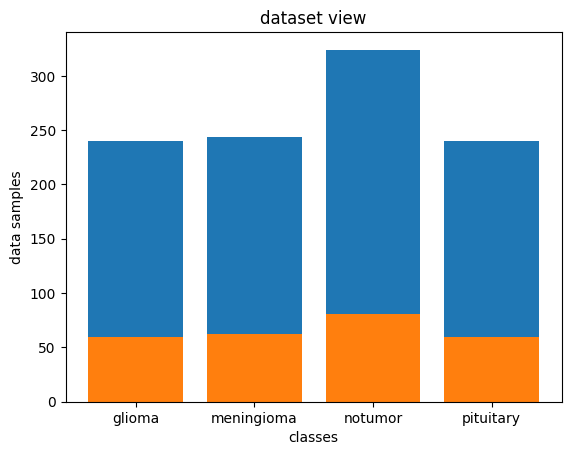

In [6]:
plt.bar(classes,train_amount)
plt.bar(classes,test_amount)
plt.title("dataset view")
plt.ylabel("data samples")
plt.xlabel("classes")
plt.plot()

In [7]:
print(len(train_list))
print(len(test_list))

1048
263


In [8]:


x_transform = A.Compose(
    [
     A.Resize(512,512),
     A.HorizontalFlip(p=0.5),
     A.VerticalFlip(p=0.5),
     ToTensorV2(),
     ]
)
x_transform_v2 = A.Compose(
    [
     A.Resize(512,512),
    #  A.HorizontalFlip(p=0.5),
    #  A.VerticalFlip(p=0.5),
     A.Rotate(limit = 180,p=0.5),
     ToTensorV2(),
     ]
)

test_transform = A.Compose([
     A.Resize(512,512),
     ToTensorV2(),
]
)

In [9]:

class BrainMRI(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = self.image_paths[idx][0]
        # image = cv2.imread(image_filepath)

        label = torch.tensor(self.image_paths[idx][1])
        # print(label)
        if self.transform != False:
            image = self.transform(image=image)["image"]
        else:
            image = test_transform(image=image)["image"]
        return image.float(), label



train_dataset = BrainMRI(train_list,x_transform_v2)
test_dataset = BrainMRI(test_list)

In [18]:
# class TumorClassifier(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.cnv1 = nn.Conv2d(3,16,kernel_size=(3,3),stride=1,padding =0)
#     self.a1 = nn.ReLU()
#     self.m1 = nn.AvgPool2d((2,2))
#     self.cnv2 = nn.Conv2d(16,64,kernel_size=(5,5),stride=1,padding =0)
#     self.a2 = nn.ReLU()
#     self.m2 = nn.AvgPool2d((2,2))
#     self.cnv3 = nn.Conv2d(64,128,kernel_size=(9,9),stride = 2, padding =0)
#     self.a3 = nn.ReLU()
#     self.m3 = nn.AvgPool2d((5,5))
#     # self.cnv4 = nn.Conv2d(128,256,kernel_size=(9,9),stride = 1, padding =0)
#     # self.a4 = nn.ReLU()
#     # self.m3 = nn.AdaptiveAvgPool2d(5)
#     self.flat = nn.Flatten()
#     self.d1 = nn.Linear(15488,256)
#     self.a5 = nn.ReLU()
#     self.do = nn.Dropout(0.3)
#     self.d2 = nn.Linear(256,128)
#     self.a6 = nn.ReLU()
#     # self.bn = nn.BatchNorm2d(128)
#     self.d3 = nn.Linear(128,4)
#   def forward(self,x):
#     x = self.a1(self.cnv1(x))
#     x = self.m1(x)
#     x = self.a2(self.cnv2(x))
#     x = self.m2(x)
#     x = self.a3(self.cnv3(x))
#     x = self.m3(x)
#     # x = self.a4(self.cnv4(x))
#     # x = self.m4(x)
#     x = self.flat(x)
#     x = self.do(self.a5(self.d1(x)))
#     x = self.a6(self.d2(x))
#     x = self.d3(x)
#     x = F.softmax(x)
#     return x

class TumorClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Sequential(*[
        nn.Conv2d(3,4,(3,3),stride =1,padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(4),
        nn.Conv2d(4,6,(3,3),stride=1,padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(6),
        nn.Conv2d(6,8,(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        nn.MaxPool2d((2,2),stride=2,padding=0),
        ]
    )
    self.l2 = nn.Sequential(*[
        nn.Conv2d(8,10,(3,3),stride =1,padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(10),
        nn.Conv2d(10,12,(3,3),stride=1,padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        nn.Conv2d(12,16,(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2,padding=0),
        ]
    )
    self.l3 = nn.Sequential(*[
      nn.Conv2d(16,32,(3,3),stride =1,padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.Conv2d(32,40,(3,3),stride=1,padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(40),
      nn.Conv2d(40,64,(3,3),stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d((2,2),stride=2,padding=0),
      ]
    )
    self.l4 = nn.Sequential(*[
      nn.Conv2d(64,80,(3,3),stride =1,padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(80),
      nn.Conv2d(80,100,(3,3),stride=1,padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(100),

      nn.Conv2d(100,128,(3,3),stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d((2,2),stride=2,padding=0),
      ]
    )
    self.l5 = nn.Sequential(*[
      nn.Conv2d(128,160,(3,3),stride =1,padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(160),
      nn.Conv2d(160,200,(3,3),stride=1,padding = 1),
      nn.ReLU(),
      nn.BatchNorm2d(200),
      nn.Conv2d(200,256,(3,3),stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d((2,2),stride=2,padding=0),
      ]
    )
    self.flat = nn.Flatten()
    self.d1 = nn.Linear(65536,256)
    self.a5 = nn.ReLU()
    self.do = nn.Dropout(0.3)
    self.d2 = nn.Linear(256,128)
    self.a6 = nn.ReLU()
    self.d3 = nn.Linear(128,4)
  def forward(self,x):
    for l in self.l1:
      x = l(x)
    for l in self.l2:
      x = l(x)
    for l in self.l3:
      x = l(x)
    for l in self.l4:
      x = l(x)
    for l in self.l5:
      x = l(x)
    x = self.flat(x)
    x = self.d1(x)
    x = self.a5(x)
    x = self.do(x)
    x = self.d2(x)
    x = self.a6(x)
    x = self.d3(x)
    x = F.log_softmax(x)

    return x

In [19]:

from torchsummary import summary
print(summary(TumorClassifier().to(torch_device), (3, 512, 512)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 512, 512]             112
              ReLU-2          [-1, 4, 512, 512]               0
       BatchNorm2d-3          [-1, 4, 512, 512]               8
            Conv2d-4          [-1, 6, 512, 512]             222
              ReLU-5          [-1, 6, 512, 512]               0
       BatchNorm2d-6          [-1, 6, 512, 512]              12
            Conv2d-7          [-1, 8, 512, 512]             440
              ReLU-8          [-1, 8, 512, 512]               0
       BatchNorm2d-9          [-1, 8, 512, 512]              16
        MaxPool2d-10          [-1, 8, 256, 256]               0
           Conv2d-11         [-1, 10, 256, 256]             730
             ReLU-12         [-1, 10, 256, 256]               0
      BatchNorm2d-13         [-1, 10, 256, 256]              20
           Conv2d-14         [-1, 12, 2

<ipython-input-18-845fbc0de46d>:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


In [20]:
def test_measure_accuracy(loader):
    acc =0
    count = 0
    err  =0
    for inputs, labels in loader:
        inputs, labels = inputs.to(torch_device), labels.to(torch_device)
        y_pred = model(inputs)
        # error = loss(y_pred,labels.data)
        acc += (torch.argmax(y_pred, 1) == labels.data).float().sum()
        count += len(labels.data)
        # err += error
    acc /= count
    print("Epoch %d: model test accuracy %.2f%% " % (epoch, acc.cpu()*100))
    return acc


In [21]:
model = TumorClassifier().to(torch_device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.5)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

n_epochs = 31
epochs = []
train_acc =[]
test_acc = []
train_loss=[]
for epoch in range(n_epochs):
    err =0
    acc = 0
    c = 0
    count  =0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(torch_device), labels.to(torch_device)
        model.train()
        y_pred = model(inputs)

        error = loss(y_pred, labels.data)
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        acc += (torch.argmax(y_pred, 1) == labels.data).float().sum()
        count += len(labels.data)
        c+=1
        err+= error.cpu()
    acc /= count
    model.eval()
    train_acc.append(acc)
    train_loss.append(err/c)
    print(f"Epoch %d: model train accuracy %.2f%% Loss: %.2f" % (epoch, acc.cpu()*100,err.cpu()/c))

    acc= test_measure_accuracy(test_dataloader)
    test_acc.append(acc)


<ipython-input-18-845fbc0de46d>:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Epoch 0: model train accuracy 38.45% Loss: 1.30
Epoch 0: model test accuracy 22.81% 
Epoch 1: model train accuracy 58.68% Loss: 1.02
Epoch 1: model test accuracy 30.42% 
Epoch 2: model train accuracy 61.16% Loss: 0.91
Epoch 2: model test accuracy 55.89% 
Epoch 3: model train accuracy 66.89% Loss: 0.81
Epoch 3: model test accuracy 64.64% 
Epoch 4: model train accuracy 71.47% Loss: 0.73
Epoch 4: model test accuracy 70.34% 
Epoch 5: model train accuracy 73.57% Loss: 0.63
Epoch 5: model test accuracy 65.78% 
Epoch 6: model train accuracy 72.14% Loss: 0.70
Epoch 6: model test accuracy 68.82% 
Epoch 7: model train accuracy 75.10% Loss: 0.62
Epoch 7: model test accuracy 74.14% 
Epoch 8: model train accuracy 75.48% Loss: 0.57
Epoch 8: model test accuracy 76.43% 
Epoch 9: model train accuracy 77.48% Loss: 0.52
Epoch 9: model test accuracy 77.95% 
Epoch 10: model train accuracy 80.06% Loss: 0.50
Epoch 10: model test accuracy 76.43% 
Epoch 11: model train accuracy 81.11% Loss: 0.45
Epoch 11: mode

KeyboardInterrupt: 

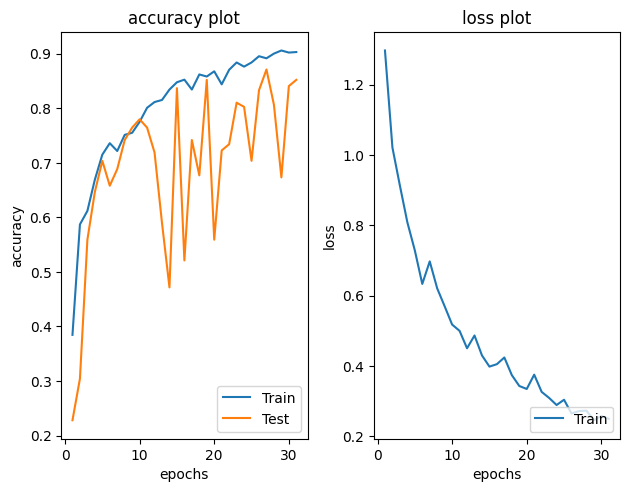

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)

train_acc = [x.cpu() for x in train_acc]
test_acc = [x.cpu() for x in test_acc]
epochs = [i for i in range(1,32)]
ax1.plot(epochs,train_acc,label='Train Accuracy')
ax1.plot(epochs,test_acc,label='Test Accuracy')
ax1.set_ylabel("accuracy")
ax1.set_xlabel("epochs")
# train_loss = [x.cpu() for x in train_loss]
# train_loss = [i.detach().numpy() for i in train_loss]
ax2.plot(epochs,train_loss)
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")
ax1.legend(['Train','Test'], loc = 'lower right')
ax2.legend(['Train'],loc = 'lower right')

plt.tight_layout()
ax1.set_title("accuracy plot")
ax2.set_title("loss plot")
plt.show()


<ipython-input-18-845fbc0de46d>:130: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


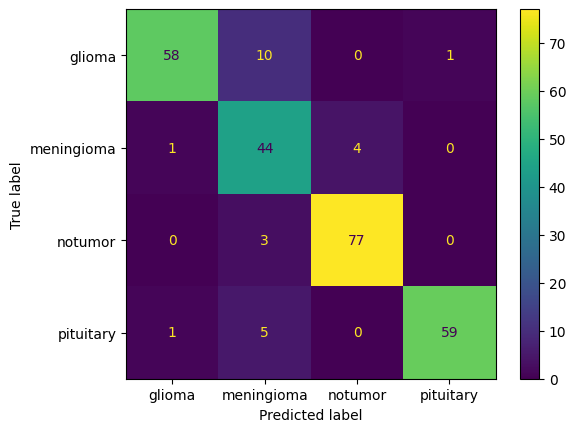

In [50]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

all_predictions = []
all_labels = []

for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(torch_device), labels.to(torch_device)
    y_pred = model(inputs)

    predictions = y_pred.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    all_predictions.extend(predictions)
    all_labels.extend(labels)

all_predictions = [np.argmax(i) for i in all_predictions]
cm = confusion_matrix(all_predictions, all_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
plt.show()


In [53]:
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
print(f"Accurcy: {accuracy_score(all_predictions,all_labels)}")
print(f"F1 score: {f1_score(all_predictions,all_labels,average='macro')}")
for i,c in enumerate(classes):
  p = cm[i,i]/np.sum(cm[:,i])
  r = cm[i,i]/np.sum(cm[i,:])
  print(f"class {c} precision: {p}, recall: {r}")
print(f"total precision: {precision_score(all_predictions,all_labels,average='macro')}")
print(f"total recall: {recall_score(all_predictions,all_labels,average='macro')}")



Accurcy: 0.9049429657794676
F1 score: 0.8981348345311945
class glioma precision: 0.9666666666666667, recall: 0.8405797101449275
class meningioma precision: 0.7096774193548387, recall: 0.8979591836734694
class notumor precision: 0.9506172839506173, recall: 0.9625
class pituitary precision: 0.9833333333333333, recall: 0.9076923076923077
total precision: 0.902573675826364
total recall: 0.9021828003776761


In [45]:
torch.save(model.state_dict(), "/content/drive/MyDrive/TumortCNN.pt")

In [56]:
class TumorClassifier_V2(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Sequential(*[
        nn.Conv2d(3,4,(3,3),stride =1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(4,6,(3,3),stride=1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(6,8,(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2,padding=0),
        ]
    )
    self.l2 = nn.Sequential(*[
        nn.Conv2d(8,10,(3,3),stride =1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(10,12,(3,3),stride=1,padding = 1),
        nn.ReLU(),
        nn.Conv2d(12,16,(3,3),stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d((2,2),stride=2,padding=0),
        ]
    )
    self.l3 = nn.Sequential(*[
      nn.Conv2d(16,32,(3,3),stride =1,padding = 1),
      nn.ReLU(),
      nn.Conv2d(32,40,(3,3),stride=1,padding = 1),
      nn.ReLU(),
      nn.Conv2d(40,64,(3,3),stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d((2,2),stride=2,padding=0),
      ]
    )
    self.l4 = nn.Sequential(*[
      nn.Conv2d(64,80,(3,3),stride =1,padding = 1),
      nn.ReLU(),
      nn.Conv2d(80,100,(3,3),stride=1,padding = 1),
      nn.ReLU(),
      nn.Conv2d(100,128,(3,3),stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d((2,2),stride=2,padding=0),
      ]
    )
    self.l5 = nn.Sequential(*[
      nn.Conv2d(128,160,(3,3),stride =1,padding = 1),
      nn.ReLU(),
      nn.Conv2d(160,200,(3,3),stride=1,padding = 1),
      nn.ReLU(),
      nn.Conv2d(200,256,(3,3),stride=1,padding=1),
      nn.ReLU(),
      nn.MaxPool2d((2,2),stride=2,padding=0),
      ]
    )
    self.flat = nn.Flatten()
    self.d1 = nn.Linear(65536,256)
    self.a5 = nn.ReLU()
    self.d2 = nn.Linear(256,128)
    self.a6 = nn.ReLU()
    self.d3 = nn.Linear(128,4)
  def forward(self,x):
    for l in self.l1:
      x = l(x)
    for l in self.l2:
      x = l(x)
    for l in self.l3:
      x = l(x)
    for l in self.l4:
      x = l(x)
    for l in self.l5:
      x = l(x)
    x = self.flat(x)
    x = self.d1(x)
    x = self.a5(x)
    x = self.d2(x)
    x = self.a6(x)
    x = self.d3(x)
    x = F.log_softmax(x)

    return x

In [57]:
model = TumorClassifier_V2().to(torch_device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01,momentum=0.5)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

n_epochs = 31
epochs = []
train_acc_v2 =[]
test_acc_v2 = []
train_loss_v2=[]
for epoch in range(n_epochs):
    err =0
    acc = 0
    c = 0
    count  =0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(torch_device), labels.to(torch_device)
        model.train()
        y_pred = model(inputs)

        error = loss(y_pred, labels.data)
        optimizer.zero_grad()
        error.backward()
        optimizer.step()
        acc += (torch.argmax(y_pred, 1) == labels.data).float().sum()
        count += len(labels.data)
        c+=1
        err+= error.cpu()
    acc /= count
    model.eval()
    train_acc_v2.append(acc)
    train_loss_v2.append(err/c)
    print(f"Epoch %d: model train accuracy %.2f%% Loss: %.2f" % (epoch, acc.cpu()*100,err.cpu()/c))

    acc= test_measure_accuracy(test_dataloader)
    test_acc_v2.append(acc)


<ipython-input-56-ed58134ae94c>:77: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Epoch 0: model train accuracy 22.33% Loss: 1.39
Epoch 0: model test accuracy 22.81% 
Epoch 1: model train accuracy 21.47% Loss: 1.39
Epoch 1: model test accuracy 22.81% 
Epoch 2: model train accuracy 22.81% Loss: 1.39
Epoch 2: model test accuracy 30.80% 
Epoch 3: model train accuracy 30.92% Loss: 1.38
Epoch 3: model test accuracy 30.80% 
Epoch 4: model train accuracy 30.92% Loss: 1.38
Epoch 4: model test accuracy 30.80% 
Epoch 5: model train accuracy 30.92% Loss: 1.38
Epoch 5: model test accuracy 30.80% 
Epoch 6: model train accuracy 30.92% Loss: 1.38
Epoch 6: model test accuracy 30.80% 
Epoch 7: model train accuracy 30.92% Loss: 1.38
Epoch 7: model test accuracy 30.80% 
Epoch 8: model train accuracy 30.92% Loss: 1.38
Epoch 8: model test accuracy 30.80% 
Epoch 9: model train accuracy 30.92% Loss: 1.38
Epoch 9: model test accuracy 30.80% 
Epoch 10: model train accuracy 30.92% Loss: 1.38
Epoch 10: model test accuracy 30.80% 
Epoch 11: model train accuracy 30.92% Loss: 1.38
Epoch 11: mode

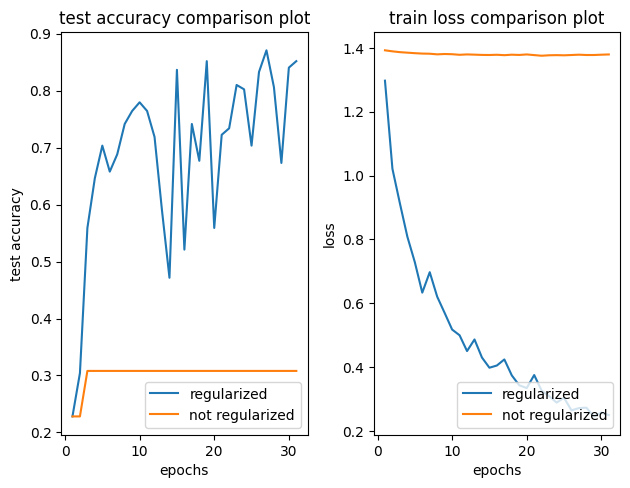

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2)

train_acc_v2 = [x.cpu() for x in train_acc_v2]
test_acc_v2 = [x.cpu() for x in test_acc_v2]
test_acc_v2 = [x.cpu() for x in test_acc_v2]

epochs = [i for i in range(1,32)]
ax1.plot(epochs,test_acc)
ax1.plot(epochs,test_acc_v2)
ax1.set_ylabel("test accuracy")
ax1.set_xlabel("epochs")
# train_loss = [x.cpu() for x in train_loss]
train_loss_v2 = [i.detach().numpy() for i in train_loss_v2]
ax2.plot(epochs,train_loss)
ax2.plot(epochs,train_loss_v2)
ax2.set_ylabel("loss")
ax2.set_xlabel("epochs")
ax1.legend(['regularized','not regularized'], loc = 'lower right')
ax2.legend(['regularized','not regularized'],loc = 'lower right')

plt.tight_layout()
ax1.set_title("test accuracy comparison plot")
ax2.set_title("train loss comparison plot")
plt.show()


# Model Architucture
It is a standard approch to decrease the height and width and to increase the channls to capture more features. For that we might need multiple layers which makes the model really heavy. I tried multiple archituctures and in some cases where flattening made a lot of features for dense layer, my model could not learn anything. Also decreasing height and width did not work and convergence speed was slow. I finally came up with this simple approch to have multiple layers each having 3 convolutions whith kernel size of 2 to keep height and width the same with small kernel sizes and increase the number of channels. Finally at the end of each layer a maxpooling is used to decrease size of image. The reason I had padding was to keep the size of image equal in all layers. In dense layers dropout is used as regularization method, and these 3 layers finally give the 4 neuron output of the model. Relu activation is used in all layers except for the last one which is our classifier and a sigmoid activation is needed to output probability of each class.
# Loss Function
MSE and Cross Entropy are two loss functions used. As seen in the lectures when we want to increase log likelihood of our classifier this loss function is used. MSE is used for regression type models.


# Optimizer
Adam is an optimization method used in gradient decent to make training smoother and faster. It uses moving average and average squared of gradient and hyperparameter beta along learning rate to optimize training. With this method weights get updated as follow:

$ m_t = \beta_1 \cdot m_{t-1} + (1 - \beta_1) \cdot g_t $

$ v_t = \beta_2 \cdot v_{t-1} + (1 - \beta_2) \cdot g_t^2 $

$ \hat{m}_t = \frac{m_t}{1 - \beta_1^t} $

$  \hat{v}_t = \frac{v_t}{1 - \beta_2^t}  $

$ w_{t+1} = w_t - \frac{\eta}{\sqrt{\hat{v}_t} + \epsilon} \cdot \hat{m}_t $

Adam is computationaly efficient, easy to implement and proved to have a great affect on training models.

Adam uses a dynamic learning rate based on moving average rather than a fixed learning rate used in SGD. SGD is simple and straight forward and tends to work better on smaller datasets. I tried both of them and when using Adam my model got stuck in a low accuracy and could not improve.

# Batch size
Using a set of input rather than a simple one we can utilize the parallization in matrix multiplication to speed up the training. Value of batch size will affect training and should be considered carefully. Having datasets with independent and balanced data we can use larger batch sizes.

# Regularization
Dropout randomly deactivates some nodes to pressure the model to enhance without using these nodes. This prevents overffiting and makes our model more general. Batch normalization on the other hand normalizes the batch results usually after a conv layer to improve the training process and stabilizes the weights. I used both of these methods . A dropout between two dense layers to prevent overfit. The 0.3 is enough and my dense layers are not large enough to use greater values. As seen in the results our model can not learn anything without regualarization.